# Objective:
# Implement the Singular Value Decomposition from scratch and apply it to real-world problems: image compression and recommendation systems.

**Part 1: Implementing SVD**


1.Write a Python function my_svd(A) that computes the SVD of a matrix A without

using any linear algebra libraries (like numpy.linalg.svd).

**Your implementation should:**

1.Compute the eigenvalues and eigenvectors of AᵀA to get V and Σ

2.Derive U from A, V, and Σ

3.Handle both rectangular and square matrices

4.Include appropriate checks for numerical stability

5.Test your function on small matrices (2x2, 3x3) and compare with numpy's implementation.





In [2]:
import numpy as np

def custom_svd(A):
    A = np.array(A, dtype=float)
    m, n = A.shape

    #compute A^T A
    ATA = A.T @ A

    #eigen decomposition of A^T A
    eigvals_V, V = np.linalg.eigh(ATA)

    #sort eigenvalues and vectors in descending order
    idx_V = np.argsort(eigvals_V)[::-1]
    eigvals_V = eigvals_V[idx_V]
    V = V[:, idx_V]

    #compute singular values
    singular_values = np.sqrt(np.clip(eigvals_V, 0, None))
    Sigma = np.zeros((m, n))
    for i in range(min(m, n)):
        Sigma[i, i] = singular_values[i]

    #compute U = A V / sigma
    U = np.zeros((m, m))
    for i in range(min(m, n)):
        if singular_values[i] > 1e-10:  # avoid division by zero
            u = A @ V[:, i] / singular_values[i]
            U[:, i] = u

    #if m > n, complete U using Gram-Schmidt or identity (optional)
    if m > n:
        #orthonormalize remaining columns (quick Gram-Schmidt)
        for i in range(n, m):
            vec = np.random.randn(m)
            for j in range(i):
                vec -= np.dot(U[:, j], vec) * U[:, j]
            vec /= np.linalg.norm(vec)
            U[:, i] = vec

    return U, Sigma, V.T


In [3]:
matrix = [[1,2],[1,3],[6,7]]
custom_svd(matrix)

(array([[ 0.22094704,  0.35784516,  0.90726471],
        [ 0.30051712,  0.86001246, -0.41239305],
        [ 0.92783181, -0.3637656 , -0.08247861]]),
 array([[9.92510611, 0.        ],
        [0.        , 1.22158449],
        [0.        , 0.        ]]),
 array([[ 0.61343979,  0.78974149],
        [-0.78974149,  0.61343979]]))

In [4]:
#testing using numpy svd
np.linalg.svd(matrix)

SVDResult(U=array([[-0.22094704, -0.35784516, -0.90726471],
       [-0.30051712, -0.86001246,  0.41239305],
       [-0.92783181,  0.3637656 ,  0.08247861]]), S=array([9.92510611, 1.22158449]), Vh=array([[-0.61343979, -0.78974149],
       [ 0.78974149, -0.61343979]]))

Hence we get the same output, which shows that the custom implmentation is correct

**Part 2: Applications of SVD **

**Principal Component Analysis :**

1.Implement PCA using your SVD function.

2.Apply it to the Iris dataset and visualize the data projected onto the first two principal components.

3.Compare your results with sklearn's PCA implementation.


---



**Image Compression :**

1.Select a grayscale image (at least 256x256 pixels).

2.Write a function that compresses the image using truncated SVD at different compression levels (k=5, 10, 20, 50).

3.Display the original and compressed images side by side with their compression ratios and PSNR values.


---


**Recommendation System :**

1.Implement a simple movie recommendation system using SVD on the MovieLens 100k dataset.

2.Show how predictions change as you vary the number of singular values used.

***Principal component analysis***

In [5]:
#PCA using custom function
def pca_custom(X, k=2):
    #must scale data before this function
    X = np.array(X, dtype=float)

    U, S, Vt = custom_svd(X)

    # Step 3: Get top k components
    components = Vt[:k]  # shape: (k, n_features)

    # Step 4: Project data onto top k components
    X_reduced = X @ components.T  # shape: (n_samples, k)

    return X_reduced


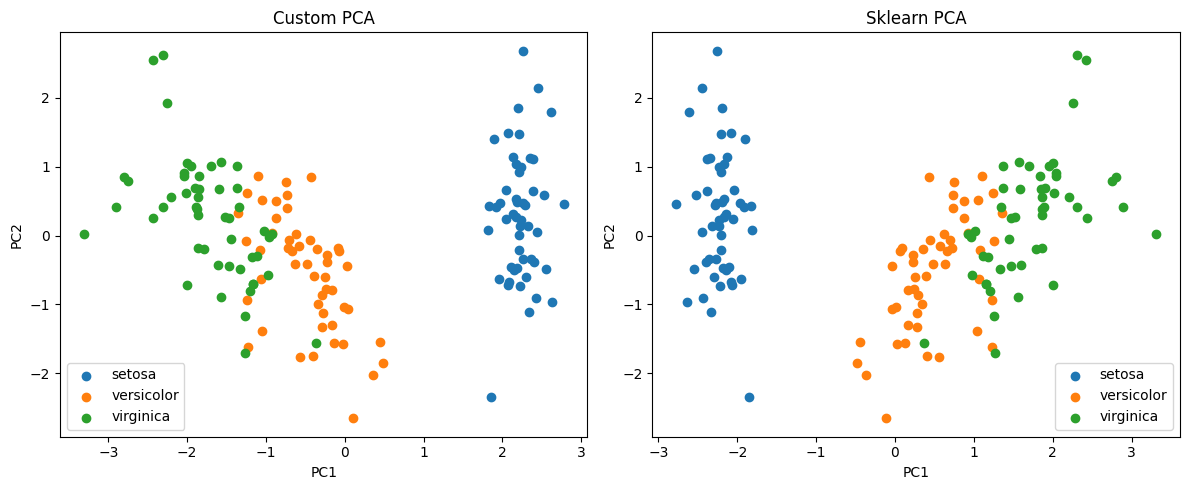

In [6]:
#import the iris dataset
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA as SklearnPCA
from sklearn.preprocessing import StandardScaler

data = load_iris()
X = data.data
y = data.target
target_names = data.target_names
X= StandardScaler().fit_transform(X)
# PCA using custom implementation
X_custom = pca_custom(X, k=2)

# PCA using scikit-learn
pca = SklearnPCA(n_components=2)
X_sklearn = pca.fit_transform(X)

#plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, name in enumerate(target_names):
    axs[0].scatter(X_custom[y == i, 0], X_custom[y == i, 1], label=name)
axs[0].set_title("Custom PCA")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

for i, name in enumerate(target_names):
    axs[1].scatter(X_sklearn[y == i, 0], X_sklearn[y == i, 1], label=name)
axs[1].set_title("Sklearn PCA")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

***Image compression***

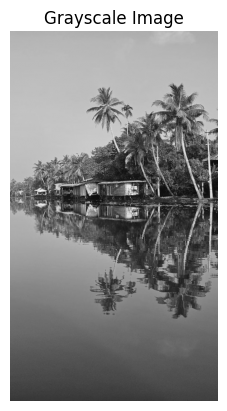

In [8]:
import matplotlib.image as mpimg
img = mpimg.imread('image.54.25.jpeg')
if img.shape[-1] == 4:
    img = img[:, :, :3]

# Convert RGB to grayscale using standard luminance formula
# Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

# Display grayscale image
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

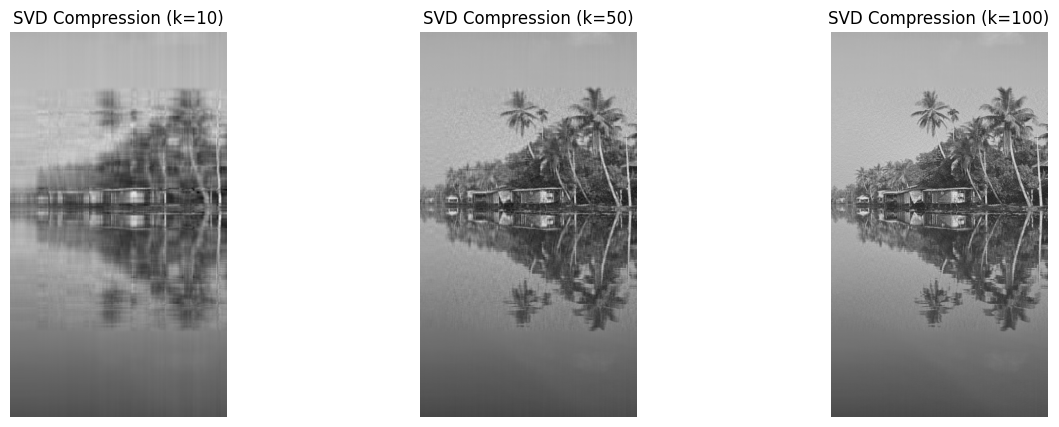

In [12]:
def compress_svd(img_gray, k):
    U, Sigma, VT = custom_svd(img_gray)
    # Truncate to top-k components
    U_k = U[:, :k]
    S_k = Sigma[:k, :k]
    VT_k = VT[:k, :]
    # Reconstruct the image
    compressed = U_k @ S_k @ VT_k
    return compressed


# Try compression with different k
ks = [10, 50, 100]

plt.figure(figsize=(15, 5))
for i, k in enumerate(ks):
    compressed = compress_svd(gray_img, k)
    plt.subplot(1, len(ks), i + 1)
    plt.imshow(compressed, cmap='gray')
    plt.title(f"SVD Compression (k={k})")
    plt.axis('off')
plt.show()

In [21]:
def compute_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

ks = [10, 50, 100]
for i, k in enumerate(ks):
    compressed = compress_svd(gray_img, k)
    print(f"PSNR for k={k}: {compute_psnr(gray_img, compressed)}")


PSNR for k=10: 21.05213598195913
PSNR for k=50: 25.042707344186297
PSNR for k=100: 27.829421240295687


So we can see that the quality of the image increases as the number of top components taken increases. The higher the PSNR value, better is the quality of the compressed image (That is, closer it is to the original image)

***Movie Recommendation System***

In [16]:
import pandas as pd

# Load MovieLens 100k data
ratings = pd.read_csv("u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
movies = pd.read_csv("u.item", sep="|", encoding='latin-1', header=None, usecols=[0, 1], names=["movie_id", "title"])

# Create user-item rating matrix
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R = user_item_matrix.values
user_ids = user_item_matrix.index
movie_ids = user_item_matrix.columns

# Apply custom SVD
U, Sigma, VT = custom_svd(R)



# Recommendation function
def recommend_movies(user_index, R_original, R_predicted, movie_ids, movies_df, top_n=5):
    user_rated = np.where(R_original[user_index] > 0)[0]
    user_pred_ratings = R_predicted[user_index]

    unrated_indices = [i for i in range(len(user_pred_ratings)) if i not in user_rated]
    top_indices = sorted(unrated_indices, key=lambda x: user_pred_ratings[x], reverse=True)[:top_n]

    top_movie_ids = movie_ids[top_indices]
    return movies_df[movies_df['movie_id'].isin(top_movie_ids)]

def recommend(user_id):
    user_idx = list(user_ids).index(user_id)
    recommendations = recommend_movies(user_idx, R, R_pred, movie_ids.to_numpy(), movies)

    # Output
    print(f"Top recommendations for User {user_id}:")
    print(recommendations[['title']])


In [20]:
k_vary =[5,10,20,50]
for k in k_vary:
    U_k = U[:, :k]
    S_k = Sigma[:k, :k]
    VT_k = VT[:k, :]

    # Reconstruct the ratings matrix
    R_pred = U_k @ S_k @ VT_k
    print(f"Taking value of k as : {k}")
    recommend(50)
    recommend(79)
    print("\n")

Taking value of k as : 5
Top recommendations for User 50:
                        title
6       Twelve Monkeys (1995)
126     Godfather, The (1972)
257            Contact (1997)
272               Heat (1995)
301  L.A. Confidential (1997)
Top recommendations for User 79:
                        title
126     Godfather, The (1972)
236      Jerry Maguire (1996)
299      Air Force One (1997)
301  L.A. Confidential (1997)
474      Trainspotting (1996)


Taking value of k as : 10
Top recommendations for User 50:
                               title
6              Twelve Monkeys (1995)
92   Welcome to the Dollhouse (1995)
236             Jerry Maguire (1996)
257                   Contact (1997)
301         L.A. Confidential (1997)
Top recommendations for User 79:
                         title
13          Postino, Il (1994)
180  Return of the Jedi (1983)
299       Air Force One (1997)
301   L.A. Confidential (1997)
474       Trainspotting (1996)


Taking value of k as : 20
Top recommendations